- <https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html>

- <https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html#Generalizing-E%E2%80%93M:-Gaussian-Mixture-Models>

In [92]:
from os import getenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture #covariance_type='diag'
from scipy.spatial import distance

In [67]:
kg = pd.read_csv('spotify_tracks_metadata.csv')

In [72]:
kg_slim = kg[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']]

In [74]:
kg_slim.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.585,0.436,10,-8.761,1,0.0601,0.72100,0.000013,0.1050,0.132,143.874,242014,4
1,0.680,0.826,0,-5.487,1,0.0309,0.02120,0.000012,0.5430,0.644,118.051,215627,4
2,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,200040,4
3,0.700,0.722,7,-3.558,0,0.0369,0.22100,0.000000,0.2720,0.756,90.989,140526,4
4,0.662,0.413,0,-7.357,1,0.0299,0.21300,0.000000,0.1340,0.467,93.005,161385,4


In [78]:
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('gauss', GaussianMixture(
        n_components=5,           # could tune by minimizing aic or bic
        covariance_type='diag',   # 'full' is best, 'spherical' is fastest
        n_init=10))])    # Hands-On ML warns that default n_init=1 is too low

pipe.fit(kg_slim)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gauss',
                 GaussianMixture(covariance_type='diag', n_components=5,
                                 n_init=10))])

In [104]:
# Like coordinates in multidimensional song-space, relative to clusters;
# Or like affiliation scores to distinct song distributions;
db_song_coords = pipe.predict_proba(kg_slim)

## the model (pipe) and what it says about the database songs (db_song_coords) could be saved offline

## then, via the app, we provide a new_song (or song_name + artist_name);
## the app queries spotify for this new_song's features;
## feeds those audio_features to our pre-trained model; 
## and compares the read-out to its offline analysis of database songs (db_song_coords).

In [103]:
"""Setting up APIs for this notebook"""
from client.spotify_client import *
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

SPOTIFY_API_KEY = getenv("SPOTIFY_API_KEY")
SPOTIFY_API_KEY_SECRET = getenv("SPOTIFY_API_KEY_SECRET")


# get spotify API 
spotify = SpotifyAPI(SPOTIFY_API_KEY, SPOTIFY_API_KEY_SECRET)

# get spotiPy API (wrapper for spotify API)
auth_manager = SpotifyClientCredentials(SPOTIFY_API_KEY, SPOTIFY_API_KEY_SECRET)
spotiPy = spotipy.Spotify(auth_manager=auth_manager)

In [105]:
# html could accept user input, typed into 2 separate fields; hit a button
user_input_song = 'superstition'
user_input_artist = 'stevie wonder'

# app@route('/') takes user_input_song, user_input_artist...feeds APIs

# spotify API -- from (song_name, artist_name) to track's (Spotify ID);
new_song = spotify.search(
    {'track':user_input_song, 'artist':user_input_artist}, search_type='track')
new_song_spot_id = new_song['tracks']['items'][0]['id']

# spotiPy API -- from track's (Spotify ID) to its (audio_features):
new_song_features = spotiPy.audio_features(tracks=[new_song_spot_id])

# arrange new_song's audio_features to match feature matrix used to train model;
new_song_ready = pd.DataFrame(new_song_features)[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']]

# app unpickles saved model (pipe) and saved model output (db_song_coords);
# new_song_ready meets the model;
new_song_coords = pipe.predict_proba(new_song_ready)

# use scipy.distance.cdist(...'cosine') to get cosine similarity scores,
# comparing new_song to everything stored in database
distances = distance.cdist(db_song_coords, new_song_coords, 'cosine')

q=track%3Asuperstition+artist%3Astevie+wonder&type=track


In [106]:
distances.shape

(439893, 1)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

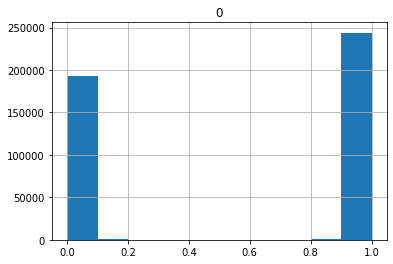

In [113]:
pd.DataFrame(distances).hist()

Well, that did not work well. Maybe we need more clusters. I chose an arbitrary number, n_components=5.

pipe.fit() took 2 minutes on my laptop. With unlimited time to train a model offline, we can come up with something.

This site shows how to tune n_components, to minimize aic or bic, both built-in attributes of a fitted GaussianMixture model.
- <https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html#Generalizing-E%E2%80%93M:-Gaussian-Mixture-Models>

Also, covariance_type could be set to 'full', for a better fitting model.

If GaussianMixture doesn't cut it, any other clustering (unsupervised) model that has a predict_proba method would work well with the general steps outlined in this notebook.